In [16]:
%pip install pyarrow

     ---------------------------------------- 25.3/25.3 MB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Romain\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import csv
import re
import polars as pl

In [ ]:
from __future__ import annotations
import re, csv, pathlib, polars as pl

ROOT      = pathlib.Path(r"C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS")
DATASETS = [
    "project",
    "projectDeliverables",
    "projectPublications",
    "reportSummaries",
    "organization",
    "euroSciVoc",
    "topics",
    "webItem",
    "webLink",
    "legalBasis",
]
OUTDIR    = ROOT / "combined"
OUTDIR.mkdir(exist_ok=True)

###############################################################################
# 2.  Generic cleaner –– parameterised version of the loop you wrote
###############################################################################
_PROJECT_ID_RE = re.compile(r"^(?:19|20)\d{2}")
_GENERIC_NUM_RE  = re.compile(r"\d{4}")

import csv, pathlib, polars as pl, re

import csv, re, pathlib
import polars as pl                       #  >=0.20

import csv, pathlib, re
import polars as pl                       # ≥ 0.20


def _clean_one_file(csv_path: pathlib.Path,
                    number_regex: re.Pattern[str], dataset: str) -> pl.DataFrame:
    """
    Clean a CORDIS CSV whose long *objective* field sometimes explodes into
    extra columns because of stray quotes / semicolons.

    Strategy
    --------
    * A well-formed row has 21 semicolon-separated columns.
    * If we get more than 21 columns we treat columns 16 … -4 as belonging
      to *objective* and stitch them back together with a semicolon.
    * The last three columns are   contentUpdateDate | rcn | grantDoi.
    """
    # ---------- constants --------------------------------------------------
    if dataset=="project":
        EXPECTED_COLS   = 20          # final width
        TITLE_COL       = 3           # 0-based index of *title*
        DATE1_COL       = 4           # 0-based index of startDate
        DATE2_COL       = 5           # 0-based index of endDate
        OBJECTIVE_COL   = 16          # 0-based index of objective
        TRAILING_KEEP   = 3           # last three fixed columns
    elif dataset=="organization":
        EXPECTED_COLS   = 25          # final width
        TITLE_COL       = 3           # 0-based index of *title*
        DATE1_COL       = 4           # 0-based index of startDate
        DATE2_COL       = 5           # 0-based index of endDate
        OBJECTIVE_COL   = 4           # 0-based index of objective
        TRAILING_KEEP   = 20           # last three fixed columns
    else:
        EXPECTED_COLS   = 20          # final width
        TITLE_COL       = 3           # 0-based index of *title*
        DATE1_COL       = 4           # 0-based index of startDate
        DATE2_COL       = 5           # 0-based index of endDate
        OBJECTIVE_COL   = 16          # 0-based index of objective
        TRAILING_KEEP   = 3           # last three fixed columns



    date_rx   = re.compile(r"\d{4}-\d{2}-\d{2}$")
    is_date   = lambda s: (s == "") or bool(date_rx.match(s))

    tmp_clean = csv_path.with_suffix(".cleaned.csv")

    with csv_path.open(encoding="utf-8", newline="") as fin, \
         tmp_clean.open("w", encoding="utf-8", newline="") as fout:

        writer = csv.writer(
            fout,
            delimiter="|",
            quotechar='"',
            quoting=csv.QUOTE_MINIMAL,
            lineterminator="\n",
        )

        # ---------- iterate raw lines -------------------------------------
        for raw in fin:
            #print(raw)
            raw = raw.rstrip("\n")
            #print(raw)
            cells = raw.split(";")                     # blind split

            # ---- 1️⃣  repair *title* if dates are not where they belong --
            if (len(cells) > EXPECTED_COLS) and  (not is_date(cells[DATE1_COL]) or not is_date(cells[DATE2_COL])) and dataset=="project":
                # look for the first position where *two successive* cells
                # are both valid dates / nulls
                i = DATE1_COL
                while i + 1 < len(cells):
                    if is_date(cells[i]) and is_date(cells[i + 1]):
                        break
                    i += 1
                else:
                    # cannot find a valid date pair → give up on this line
                    continue

                head   = cells[:TITLE_COL]             # 0 … 2
                title  = ";".join(cells[TITLE_COL:i])  # glue spill-over
                cells  = head + [title] + cells[i:]    # rebuild the row
            # ---- 2️⃣  repair *objective* overflow ------------------------
            if len(cells) > EXPECTED_COLS and (dataset=="project" or  dataset=="organization"):
                head = cells[:OBJECTIVE_COL]
                tail = cells[-TRAILING_KEEP:]
                obj  = ";".join(cells[OBJECTIVE_COL:-TRAILING_KEEP])
                cells = head + [obj] + tail
                #print("here 2")

            # ---- 3️⃣  pad short rows, skip malformed ---------------------
            if len(cells) < EXPECTED_COLS and (dataset=="project" or  dataset=="organization"):
                cells.extend([""] * (EXPECTED_COLS - len(cells)))
                #print("here again")

            if len(cells) != EXPECTED_COLS and (dataset=="project" or  dataset=="organization"):            # still wrong → skip
                #print(cells)
                continue

            # ---- 4️⃣  cell-level clean-ups -------------------------------
            cleaned: list[str] = []
            for cell in cells:

                if cell in ('""', ""):
                    cell = ""
                else:
                    cell = (cell.replace("\t", " ")
                                 .replace('"""', '"')
                                 .strip())
                    if number_regex.fullmatch(cell):
                        cell = cell.lstrip("0") or "0"
                cleaned.append(cell.strip('"'))
            cleaned[-1]=cleaned[-1].replace('"','').replace(',','')
            cleaned[0]=cleaned[0].replace('"','')
            writer.writerow(cleaned)

    # ---------- read into Polars (all Utf8) -------------------------------
    return pl.read_csv(
        tmp_clean,
        separator="|",
        quote_char='"',
        has_header=True,
        infer_schema_length=0,
        null_values=[""],
        truncate_ragged_lines=True,
    )


def combine_all_programmes() -> None:
    from pathlib import Path
    for dataset in DATASETS:
        combined: list[pl.DataFrame] = []

        for i,programme_dir in enumerate(ROOT.iterdir()):
            if not programme_dir.is_dir():
                continue
            csv_file = programme_dir / f"{dataset}.csv"
            if not csv_file.exists():
                continue

            regex = _PROJECT_ID_RE if dataset == "project" else _GENERIC_NUM_RE
            df    = _clean_one_file(csv_file, regex, dataset)
            print(programme_dir)
            # ---------- type coercions matching your original code ----------
            if dataset == "project":
                df = (
                    df
                    .with_columns([
                        pl.col("id"),#.cast(pl.Int64),
                        pl.col("acronym").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("status").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("title").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("legalBasis").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("topics").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("frameworkProgramme").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("masterCall").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("subCall").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("fundingScheme").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("nature").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("objective").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("grantDoi").cast(pl.Utf8, strict=False).str.strip_chars('"'),
                        pl.col("totalCost").cast(pl.Utf8, strict=False).str.strip_chars('"').str.replace_all('"','').str.replace(",",".").cast(pl.Float64),
                        pl.col("ecMaxContribution").cast(pl.Utf8, strict=False).str.strip_chars('"').str.replace_all('"','').str.replace(",",".").cast(pl.Float64),
                        pl.col("startDate").cast(pl.Utf8, strict=False).str.strip_chars('"').str.strptime(pl.Date, "%Y-%m-%d", strict=False),
                        pl.col("endDate").cast(pl.Utf8, strict=False).str.strip_chars('"').str.strptime(pl.Date, "%Y-%m-%d", strict=False),
                        pl.col("ecSignatureDate").cast(pl.Utf8, strict=False).str.strip_chars('"').str.strptime(pl.Date, "%Y-%m-%d", strict=False),
                        pl.col("contentUpdateDate").cast(pl.Utf8, strict=False).str.strip_chars('"').str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
                        pl.col("rcn").cast(pl.Int64),
                    ])
                    .with_columns(
                        pl.lit(programme_dir.name).alias("programmeFolder")   # <-- NEW COLUMN
                    )
                )
            elif dataset == "organization":
                df = df.with_columns([
                    pl.col("contentUpdateDate").cast(pl.Utf8, strict=False).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
                    pl.col("totalCost").cast(pl.Utf8, strict=False).str.replace(",",".").cast(pl.Float64),
                ])
            elif dataset == "projectDeliverables":
                df = df.with_columns([
                    #pl.col("projectID").cast(pl.Int64),
                    pl.col("contentUpdateDate").cast(pl.Utf8, strict=False)
                    .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
                ])
            elif dataset == "projectPublications":
                if programme_dir==Path(r"C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H2013"):
                    rename_map = {
                        "RECORD_ID":      "id",
                        "TITLE":          "title",
                        "AUTHOR":         "authors",
                        "DOI":            "doi",
                        "PROJECT_ID":     "projectID",
                        "JOURNAL_TITLE":  "journalTitle",
                        "PAGES":          "publishedPages",
                        "PUBLICATION_TYPE": "isPublishedAs",
                    }

                    df = df.rename(rename_map)
                else:
                    df = df.with_columns([
                        pl.col("contentUpdateDate").cast(pl.Utf8, strict=False)
                        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
                        pl.col("id").cast(pl.Utf8, strict=False)
                        .str.extract(r"^(\d+)_", 1)
                        #.cast(pl.Int64)
                        .alias("projectID"),
                    ])
            elif dataset == "reportSummaries":
                df = df.with_columns(
                    pl.col("contentUpdateDate").cast(pl.Utf8, strict=False)
                    .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
                )
            elif dataset == "organization":
                df = df.with_columns([
                    pl.col("contentUpdateDate").cast(pl.Utf8, strict=False)
                    .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
                    pl.col("totalCost").cast(pl.Utf8, strict=False)
                    .str.replace(",", ".")
                    .cast(pl.Float64),
                ])
            elif dataset == "webItem":
                df = df.with_columns(
                    pl.col("uri").cast(pl.Utf8, strict=False)
                    .str.extract(r"/files/\d+/(\d+)/", 1)
                    .cast(pl.Int64)
                    .alias("projectID"),
                )

            # ---------------------------------------------------------------
            combined.append(df)

        # --------------------------------------------------------------------
        # Write out per-dataset parquet
        # --------------------------------------------------------------------
        if combined:
            how="vertical_relaxed"
            if dataset=="projectPublications":
                how="diagonal"
            result = pl.concat(combined, how=how)
            parquet_path = OUTDIR / f"{dataset}_all.parquet"
            result.write_parquet(parquet_path)
            print(f"✔  {dataset:15s} → {parquet_path}")

In [63]:
combine_all_programmes()

C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H1984
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H1987
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H1990
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H1994
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H1998
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H2006
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H2013
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H2020
C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS\H2027
✔  project         → C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Ye

#### Consolidate projects

In [ ]:
import pathlib
import polars as pl

ROOT    = pathlib.Path(r"C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS")
OUTDIR  = ROOT / "combined"
DATASETS = [
    "project",
    "projectDeliverables",
    "projectPublications",
    "reportSummaries",
    "organization",
    "euroSciVoc",
    "topics",
    "webItem",
    "webLink",
    "legalBasis",
]

dfs = {}
for dataset in DATASETS:
    path = OUTDIR / f"{dataset}_all.parquet"
    dfs[dataset] = pl.read_parquet(path)

projects         = dfs["project"]

projects_deliv   = (
    dfs["projectDeliverables"]
    .group_by("projectID")
    .agg([
        pl.col("deliverableType").alias("list_deliverableType"),
        pl.col("url")            .alias("list_url"),
        pl.col("contentUpdateDate").alias("list_contentUpdateDate"),
    ])
)

projects_publi   = (
    dfs["projectPublications"]
    .group_by("projectID")
    .agg([
        pl.col("authors")         .alias("list_authors"),
        pl.col("title")           .alias("list_title"),
        pl.col("doi")             .alias("list_doi"),
        pl.col("journalTitle")    .alias("list_journalTitle"),
        pl.col("isPublishedAs")   .alias("list_isPublishedAs"),
        pl.col("publishedYear")   .alias("list_publishedYear"),
        pl.col("contentUpdateDate").alias("list_contentUpdateDate"),
    ])
)

report = (
    dfs["reportSummaries"]
    .group_by("projectID")
    .agg([
        pl.col("title")           .alias("list_title"),
        pl.col("attachment")      .alias("list_attachment"),
        pl.col("contentUpdateDate").alias("list_contentUpdateDate"),
    ])
)

org = (
    dfs["organization"]
    .group_by("projectID")
    .agg([
        pl.col("organisationID")  .alias("list_organisationID"),
        pl.col("country")         .alias("list_country"),
        pl.col("name")            .alias("list_name"),
        pl.col("SME")             .alias("list_SME"),
        pl.col("city")            .alias("list_city"),
        pl.col("geolocation")     .alias("list_geolocation"),
        pl.col("organizationURL") .alias("list_organizationURL"),
        pl.col("role")            .alias("list_role"),
        pl.col("ecContribution")  .alias("list_ecContribution"),
        pl.col("netEcContribution").alias("list_netEcContribution"),
        pl.col("totalCost")       .alias("list_totalCost"),
        pl.col("endOfParticipation").alias("list_endOfParticipation"),
        pl.col("activityType")    .alias("list_activityType"),
        pl.col("contentUpdateDate").alias("list_contentUpdateDate"),
    ])
)

voc = (
    dfs["euroSciVoc"]
    .group_by("projectID")
    .agg([
        pl.col("euroSciVocTitle")      .alias("list_euroSciVocTitle"),
        pl.col("euroSciVocPath")       .alias("list_euroSciVocPath"),
        pl.col("euroSciVocDescription").alias("list_description"),
    ])
)

topic = (
    dfs["topics"]
    .group_by("projectID")
    .agg([
        pl.col("topic")   .alias("list_topic"),
        pl.col("title")   .alias("list_title"),
    ])
)

web_item = dfs["webItem"]  # no aggregation

web_link = (
    dfs["webLink"]
    .group_by("projectID")
    .agg([
        pl.col("physUrl")            .alias("list_physUrl"),
        pl.col("availableLanguages") .alias("list_availableLanguages"),
        pl.col("status")             .alias("list_status"),
        pl.col("archivedDate")       .alias("list_archivedDate"),
        pl.col("type")               .alias("list_type"),
        pl.col("source")             .alias("list_source"),
        pl.col("represents")         .alias("list_represents"),
    ])
)

legal = (
    dfs["legalBasis"]
    .group_by("projectID")
    .agg([
        pl.col("legalBasis")         .alias("list_legalBasis"),
        pl.col("title")              .alias("list_title"),
        pl.col("uniqueProgrammePart").alias("list_uniqueProgrammePart"),
    ])
)

consolidated = (
    projects
    .join(projects_deliv,   left_on="id", right_on="projectID", suffix="_deliv", how="left")
    .join(projects_publi,   left_on="id", right_on="projectID", suffix="_publi", how="left")
    .join(report,           left_on="id", right_on="projectID", suffix="_report", how="left")
    .join(org,              left_on="id", right_on="projectID", suffix="_org", how="left")
    .join(web_link,         left_on="id", right_on="projectID", suffix="_link", how="left")
    .join(legal,            left_on="id", right_on="projectID", suffix="_legal", how="left")
    .join(topic,            left_on="id", right_on="projectID", suffix="_topic", how="left")
    .join(voc,              left_on="id", right_on="projectID", suffix="_voc", how="left")
)

for col in ["startDate", "endDate"]:
    if consolidated[col].dtype == pl.Utf8:
        consolidated = consolidated.with_column(
            pl.col(col).str.strptime(pl.Date, "%Y-%m-%d").alias(col)
        )

consolidated = consolidated.with_columns(
    pl.col("list_netEcContribution").list.eval(pl.element().cast(pl.Float64),parallel=True)
    .list.sum().alias("netEcContribution")
)

consolidated = consolidated.with_columns(
    pl.col("totalCost").cast(pl.Float64),
    pl.col("netEcContribution").cast(pl.Float64)
)

consolidated = consolidated.with_columns([
    pl.col("startDate").dt.year().alias("startYear"),
    pl.col("endDate").  dt.year().alias("endYear"),
    (pl.col("endDate") - pl.col("startDate")).dt.total_days().alias("durationDays"),
    (pl.col("netEcContribution") / pl.col("totalCost")).alias("ecRatio"),
])

consolidated.write_parquet(OUTDIR / "consolidated.parquet")

excluded_frameworks = ["FP1", "FP2", "FP3", "FP4", "FP5", "FP6"]

consolidated_clean = (consolidated.filter(~pl.col("frameworkProgramme").is_in(excluded_frameworks)))

consolidated_clean.write_parquet(OUTDIR / "consolidated_clean.parquet")


In [2]:
import polars as pl
import pathlib
ROOT    = pathlib.Path(r"C:\Users\Romain\OneDrive - KU Leuven\MDA\backend\data")
OUTDIR  = ROOT #/ "combined"

#consolidated = pl.read_parquet(OUTDIR / "consolidated.parquet")
consolidated_clean = pl.read_parquet(OUTDIR / "consolidated_clean.parquet")


In [ ]:
consolidated_clean.head()
#ecMaxContribution, endDate, status, legalBasis, frameworkProgramme, fundingScheme, list_title_report, list_name, list_role, list_city, list_country, list_ecContribution, list_activityType, durationDays

id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,programmeFolder,list_deliverableType,list_url,list_contentUpdateDate,list_authors,list_title,list_doi,list_journalTitle,list_isPublishedAs,list_publishedYear,list_contentUpdateDate_publi,list_title_report,list_attachment,list_contentUpdateDate_report,list_organisationID,list_country,list_name,list_SME,list_city,list_geolocation,list_organizationURL,list_role,list_ecContribution,list_netEcContribution,list_totalCost,list_endOfParticipation,list_activityType,list_contentUpdateDate_org,list_physUrl,list_availableLanguages,list_status,list_archivedDate,list_type,list_source,list_represents,list_legalBasis,list_title_legal,list_uniqueProgrammePart,list_topic,list_title_topic,list_euroSciVocTitle,list_euroSciVocPath,list_description,netEcContribution,startYear,endYear,durationDays,ecRatio
str,str,str,str,date,date,f64,f64,str,str,date,str,str,str,str,str,str,datetime[μs],i64,str,str,list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[datetime[μs]],list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[f64],list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],f64,i32,i32,i64,f64
"""624794""","""COMPACTABILITY""","""CLOSED""","""Contribution of Compact Neighb…",2014-12-01,2016-11-30,309235.2,309235.2,"""FP7-PEOPLE""","""FP7-PEOPLE-2013-IEF""",null,"""FP7""",null,"""FP7-PEOPLE-2013-IEF""","""MC-IEF""",null,"""This research investigates how…",2017-04-10 11:25:29,187874,null,"""H2013""",null,null,null,null,null,null,null,null,null,null,"[""Final Report Summary - COMPACTABILITY (Contribution of Compact Neighbourhoods to Social Sustainability)""]","[""/docs/results/624/624794/final1-table-1.jpg""]",[2017-03-07 17:25:15],"[""999446873""]","[""UK""]","[""OXFORD BROOKES UNIVERSITY""]",[null],"[""Oxford""]","[""51.7520131,-1.2578498""]","[""http://www.brookes.ac.uk""]","[""coordinator""]","[""309235.2""]",[null],[null],"[""false""]","[""HES""]",[2017-04-10 11:25:29],null,null,null,null,null,null,null,"[""FP7-PEOPLE""]","[""Specific programme ""People"" implementing the Seventh Framework Programme of the European Community for research, technological development and demonstration activities (2007 to 2013)""]",[null],"[""FP7-PEOPLE-2013-IEF""]","[""Marie-Curie Action: Intra-European fellowships for career development""]",null,null,null,0.0,2014,2016,730,0.0
"""276810""","""ARCHOSL""","""CLOSED""","""Archives of Early Human Occupa…",2011-03-01,2014-02-28,75000.0,75000.0,"""FP7-PEOPLE""","""FP7-PEOPLE-2009-RG""",null,"""FP7""",null,"""FP7-PEOPLE-2010-RG""","""MC-IRG""",null,"""A number of important archaeol…",2019-08-02 13:24:51,98178,null,"""H2013""",null,null,null,"[""Arnold, L.J., Demuro, M., Parés, J.M., Arsuaga, J.L., Aranburu, A.,"", ""Lee J. Arnold , Martina Demuro , Marta Navazo , Alfonso Benito-Calvo , Alfredo Pérez-González"", … ""F. Gutiérrez , B. Valero-Garcés , G. Desir , P. González-Sampériz , M. Gutiérrez , R. Linares , M. Zarroca , A. Moreno , J. Guerrero , C. Roqué""]","[""Luminescence dating and palaeomagnetic age constraint on hominins from Sima de los Huesos, Atapuerca, Spain"", ""OSL dating of the Middle Palaeolithic Hotel California site, Sierra de Atapuerca, north-central Spain"", … ""Late Holocene evolution of playa lakes in the central Ebro depression based on geophysical surveys and morpho-stratigraphic analysis of lacustrine terraces""]","[""http://dx.doi.org/10.1016/j.jhevol.2013.12.001"", ""10.1111/j.1502-3885.2012.00262.x"", … ""http://dx.doi.org/10.1016/j.geomorph.2012.02.013""]","[""Journal of Human Evolution"", ""Boreas"", … ""Geomorphology""]

RAG should be able to answer questions related to funding for: EuroSciVoc classifications, Topic, Projects, Organizations, legalBasis.

- Expand each of these datasets with summary statistics (some based on the dataset itself, other based on the counts of status (terminated/closed) etc.)
- Write in the prompt to for example ask if they want more information on the topics of a project, or for example some short information about the different project done by an organisation.
- ...

In [ ]:
org = pl.read_parquet(OUTDIR / "organization_all.parquet")
org_cleaned = (
    org.group_by(["organisationID","name","vatNumber","shortName","SME","activityType","street","postCode","city","country","nutsCode","geolocation","organizationURL"])
    .agg([
        pl.col("projectID")            .alias("list_projectID"),
        pl.col("projectAcronym") .alias("list_projectAcronym"),
        pl.col("rcn").alias("list_rcn"),
        pl.col("order")             .alias("list_order"),
        pl.col("role")       .alias("list_role"),
        pl.col("ecContribution")               .alias("list_ecContribution"),
        pl.col("netEcContribution")             .alias("list_netEcContribution"),
        pl.col("totalCost")         .alias("list_totalCost"),
        pl.col("endOfParticipation")         .alias("endOfParticipation"),
    ])
)
org_cleaned.head()

In [13]:
consolidated.head()

id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,programmeFolder,list_deliverableType,list_url,list_contentUpdateDate,list_authors,list_title,list_doi,list_journalTitle,list_isPublishedAs,list_publishedYear,list_contentUpdateDate_publi,list_title_report,list_attachment,list_contentUpdateDate_report,list_organisationID,list_country,list_name,list_SME,list_city,list_geolocation,list_organizationURL,list_role,list_ecContribution,list_netEcContribution,list_totalCost,list_endOfParticipation,list_activityType,list_contentUpdateDate_org,list_physUrl,list_availableLanguages,list_status,list_archivedDate,list_type,list_source,list_represents,list_legalBasis,list_title_legal,list_uniqueProgrammePart,list_topic,list_title_topic,list_euroSciVocTitle,list_euroSciVocPath,list_description,netEcContribution,startYear,endYear,durationDays,ecRatio
str,str,str,str,date,date,f64,f64,str,str,date,str,str,str,str,str,str,datetime[μs],i64,str,str,list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[datetime[μs]],list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[f64],list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],f64,i32,i32,i64,f64
"""1476""",null,null,"""Integrated Sensor-Based Robot …",1985-01-01,1988-01-01,null,null,"""FP1-ESPRIT 1""",null,null,"""FP1""",null,null,null,null,"""The objective of this project …",1992-12-04 01:04:58,8338,null,"""H1984""",null,null,null,null,null,null,null,null,null,null,null,null,null,"[null, null, … null]","[""UK"", ""PT"", … ""UK""]","[""UNIVERSITY OF NEWCASTLE UPON TYNE"", ""UNIV NOVA DE LISBOA"", … ""MARI Applied Technologies Ltd""]","[null, null, … null]","[""Newcastle upon Tyne"", ""CAPARICA"", … ""Boldon""]","[null, ""38.6633229,-9.2032444"", … null]","[null, null, … null]","[""participant"", ""participant"", … ""coordinator""]","[null, null, … null]","[null, null, … null]","[null, null, … null]","[null, null, … null]","[null, null, … null]","[1992-12-04 01:04:58, 1992-12-04 01:04:58, … 1992-12-04 01:04:58]",null,null,null,null,null,null,null,"[""FP1-ESPRIT 1""]","[""European programme (EEC) for research and development in information technologies (ESPRIT), 1984-1988""]",[null],null,null,"[""software"", ""sensors""]","[""/natural sciences/computer and information sciences/software"", ""/engineering and technology/electrical engineering, electronic engineering, information engineering/electronic engineering/sensors""]","[null, null]",0.0,1985,1988,1095,null
"""395""","""INCA""",null,"""An Integrated Network Architec…",1984-09-01,1989-09-01,null,null,"""FP1-ESPRIT 1""",null,null,"""FP1""",null,null,null,null,"""The principal purpose of the I…",1992-12-09 00:00:02,8633,null,"""H1984""",null,null,null,null,null,null,null,null,null,null,null,null,null,"[null, null, … null]","[""IT"", ""IT"", … ""UK""]","[""Ingegneria C. Olivetti and C. SpA"", ""System Wizards Srl"", … ""Birkbeck College, University of London""]","[null, null, … null]","[""Pozzuoli Napoli"", ""Torino"", … ""London""]","[""40.8349492,14.1067963"", ""45.0993613,7.6747093"", … ""51.5199928,-0.1299654""]","[null, null, … null]","[""participant"", ""participant"", … ""participant""]","[null, null, … null]","[null, null, … null]","[null, null, … null]","[null, null, … null]","[null, null, … null]","[1992-12-09 00:00:02, 1992-12-09 00:00:02, … 1992-12-09 00:00:02]",null,null,null,null,null,null,null,"[""FP1-ESPRIT 1""]","[""European programme (EEC) for research and development in information technologies (ESPRIT), 1984-1988""]",[null],null,null,"[""software"", ""telecommunications""]","[""/natural sciences/computer and in

In [41]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def lang_text(text):
    try:
        return detect(text)
    except:
        return "unknown"

languages=consolidated_clean.filter(pl.col('status').is_not_null()).to_pandas()['title'].apply(lang_text)
unique_languages = languages.unique()
print(unique_languages)
language_counts = languages.value_counts()
print(language_counts)

#print("English coverage:", consolidated.to_pandas()['title'].apply(is_english).mean())


['en' 'de' 'it' 'sw' 'ro' 'pl' 'pt' 'ca' 'af' 'es' 'nl' 'no' 'da' 'vi'
 'et' 'fr' 'cy' 'tl' 'so' 'sv' 'tr' 'id' 'lt' 'hu' 'fi' 'hr' 'sl'
 'unknown' 'sk' 'cs']
title
en         56676
de          1012
it           343
ro           238
ca           224
fr           144
da           131
es            81
tl            69
vi            69
nl            61
pt            60
af            46
no            43
id            36
so            29
sv            24
pl            15
cy            14
et            11
fi            10
sw             9
hr             6
sl             5
lt             3
tr             2
unknown        2
hu             1
sk             1
cs             1
Name: count, dtype: int64


In [ ]:
status_prediction_model(consolidated_clean.to_pandas())

🧹 Preparing data...
💡 Embedding text...
Loading saved embeddings for column 'title'...
Fitting SVD for column 'title'...
Loading saved embeddings for column 'objective'...
Fitting SVD for column 'objective'...
Loading saved embeddings for column 'topic_title'...
Fitting SVD for column 'topic_title'...


[I 2025-05-12 21:30:14,899] A new study created in memory with name: no-name-7695811c-115a-4d9f-a17b-3fc16faf602a


🧱 Building pipeline...
🎯 Training model with Optuna...


c:\Users\Romain\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['AW', 'GM', 'GN', 'GY', 'JE', 'MV'] will be ignored
  warnings.warn(
c:\Users\Romain\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['CARRETERA AL AJUSCO NUM. 377'] will be ignored
  warnings.warn(
c:\Users\Romain\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['FI', 'GA', 'NO', 'RO'] will be ignored
  warnings.warn(
c:\Users\Romain\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['COMPUTATIONAL TOPOLOGY', 'ELECTRICAL ENGINEERING, ELECTRONIC ENGINEERING, INFORMATION ENGINEERING', 'FLORICULTURE', 'FRUGAL ARTIFICIAL INTELLIGENCE', 'GENERAL MEDICINE', 'HISTORY OF PHILOSOPHY', 'INFORMATION ENGINEERING', 'ISLAMIC SCHOOLS', 'OTHER SOCIAL SCIENCES', 'SILICENE', 'ULTRAVIOLET LASERS'] will be ignored
  warnings.warn(
c:\Users\Romain\anacond

KeyboardInterrupt: 

: 

In [2]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import scipy.sparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN

from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier

from evidently import Report
from evidently.presets import DataDriftPreset

import optuna


# --- Custom Transformers ---
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        self.col = X.name
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(X)
        return self
    def transform(self, X):
        return self.mlb.transform(X)
    def get_feature_names_out(self, input_features=None):
        return [f"{self.col}_{cls}" for cls in self.mlb.classes_]
    def get_params(self, deep=True):
        return {}
    def set_params(self, **params):
        return self

class AnomalyScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = IsolationForest(n_estimators=200, contamination=0.1, random_state=42)

    def fit(self, X, y=None):
        self.model.fit(X)
        return self

    def transform(self, X):
        scores = -self.model.decision_function(X)
        return np.hstack([X, scores.reshape(-1, 1)])

# --- Step 1: Data Preparation ---
def prepare_data(df, is_train=True, model_dir="model_artifacts"):
    df = df.copy()
    
    if is_train:
        df['status'] = df['status'].astype(str).str.upper()
        df = df[df['status'].isin(['CLOSED', 'TERMINATED'])]
        df['label'] = df['status'].map({'CLOSED': 0, 'TERMINATED': 1})
        assert df['label'].notna().all(), "Label column still has NaNs!"

    multilabel_fields = [
        'list_country', 'list_activityType', 'list_deliverableType',
        'list_availableLanguages', 'list_euroSciVocTitle'
    ]

    def extract_intermediate_levels(paths):
        tokens = []
        if isinstance(paths, list):
            for p in paths:
                parts = p.strip('/').split('/')
                tokens.extend(parts[:-1])
        return list(set(tokens))
    df['euroSciVoc_intermediate'] = df['list_euroSciVocPath'].apply(extract_intermediate_levels)
    multilabel_fields.append('euroSciVoc_intermediate')
    
    for col in multilabel_fields:
        df[col] = df[col].apply(lambda x: [] if x is None else (x.tolist() if hasattr(x, 'tolist') else x))
        df[col] = df[col].apply(lambda x: list(x) if not isinstance(x, list) else x)
        df[col] = df[col].apply(lambda x: [item for item in x if item is not None])
        df[col] = df[col].apply(lambda x: [str(item).upper() for item in x])

    
    def split_languages(lang_list):
        if not isinstance(lang_list, list):
            return []
        result = []
        for entry in lang_list:
            if isinstance(entry, str):
                result.extend(entry.split(","))
        return result

    df["list_availableLanguages"] = df["list_availableLanguages"].apply(split_languages)
        
    df['topic_title'] = df['list_title_topic'].apply(
        lambda x: (x.tolist() if hasattr(x, 'tolist') else x)[0] if x is not None and len(x) > 0 else "unknown_topic"
    )

    for col in ['title', 'objective', 'topic_title']:
        df[col] = df[col].fillna("").astype(str)

    df['n_partners'] = df['list_name'].apply(
        lambda x: len(x.tolist()) if x is not None and hasattr(x, 'tolist') else (len(x) if isinstance(x, list) else 0)
    )

    df['n_country'] = df['list_country'].apply(
        lambda x: len(x.tolist()) if x is not None and hasattr(x, 'tolist') else (len(x) if isinstance(x, list) else 0)
    )

    df['n_sme'] = df['list_SME'].apply(
        lambda x: sum(1 for i in (x.tolist() if hasattr(x, 'tolist') else x) if i is True)
        if x is not None and (hasattr(x, 'tolist') or isinstance(x, list)) else 0
    )

    return df

# --- Step 2: Text Embedding ---
def compute_embeddings(df, text_columns, model_name='paraphrase-multilingual-MiniLM-L12-v2', svd_dim=50):
    model = SentenceTransformer(model_name)
    os.makedirs("model_artifacts", exist_ok=True)
    os.makedirs("embeddings", exist_ok=True)
    for col in text_columns:
        embedding_file = f"embeddings/{col}_embeddings.npy"
        svd_file = f"model_artifacts/{col}_svd.pkl"
        if os.path.exists(embedding_file):
            print(f"Loading saved embeddings for column '{col}'...")
            embeddings = np.load(embedding_file)
        else:
            print(f"Computing embeddings for column '{col}'...")
            embeddings = model.encode(df[col].tolist(), show_progress_bar=True)
            np.save(embedding_file, embeddings)

        print(f"Fitting SVD for column '{col}'...")
        svd = TruncatedSVD(n_components=svd_dim, random_state=42)
        svd.fit(embeddings)
        joblib.dump(svd, svd_file)

        reduced = svd.transform(embeddings)
        embed_df = pd.DataFrame(reduced, columns=[f'{col}_embed_{i}' for i in range(reduced.shape[1])])
        embed_df.index = df.index  # Force matching index
        df = pd.concat([df, embed_df], axis=1)
    return df


# --- Step 3: Build Preprocessor ---
def build_preprocessor(numeric_features, categorical_features, multilabel_fields):
    numeric_pipeline = SKPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('anomaly', AnomalyScoreTransformer()),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = SKPipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformers = [
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
      *[(f'mlb_{col}', MultiLabelBinarizerTransformer(), col) for col in multilabel_fields]]
        

    return ColumnTransformer(transformers, sparse_threshold=0.0)

# --- Step 4: Build Pipeline ---
def build_pipeline(preprocessor, base_model, k=250):
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('anomaly', AnomalyScoreTransformer()),
        ('resample', SMOTEENN()),
        ("variance_filter", VarianceThreshold(threshold=0.0)),
        ('feature_select', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', CalibratedClassifierCV(estimator=base_model, method='isotonic', cv=3))
    ])

# --- Step 5: Drift Monitoring ---
def monitor_drift(reference, current, feature_names, output_html='drift_report.html'):
    ref_df = pd.DataFrame(reference, columns=feature_names)
    cur_df = pd.DataFrame(current, columns=feature_names)
    
    report = Report(metrics=[DataDriftPreset()])
    report.run(reference_data=ref_df, current_data=cur_df)
    report.save_html(output_html)
    print(f"✅ Drift report saved to {output_html}")


# --- Step 6: Evaluation + SHAP ---
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Evaluation")
    plt.tight_layout()
    plt.show()

    X_proc = model.named_steps['preprocessor'].transform(X_test)
    if scipy.sparse.issparse(X_proc):
        X_proc = X_proc.toarray()

    selector = model.named_steps['feature_select']
    X_selected = selector.transform(X_proc)

    explainer = shap.Explainer(model.named_steps['classifier'].base_estimator, feature_names=feature_names)
    shap_values = explainer(X_selected)
    shap.summary_plot(shap_values, X_selected)

# --- Final Orchestration ---
def status_prediction_model(df):
    os.makedirs("model_artifacts", exist_ok=True)
    print("🧹 Preparing data...")
    df = prepare_data(df, is_train=True)
    print("💡 Embedding text...")
    df = compute_embeddings(df, ['title', 'objective', 'topic_title'])

    text_embed_cols = [col for col in df.columns if '_embed_' in col]
    numeric_features = ['durationDays', 'startYear', 'ecMaxContribution', 'totalCost',
                        'n_partners', 'n_country', 'n_sme'] + text_embed_cols
    categorical_features = ['frameworkProgramme', 'fundingScheme', 'legalBasis', 'nature']
    multilabel_fields =  ['list_country', 'list_activityType', 'list_deliverableType',
        'list_availableLanguages', 'list_euroSciVocTitle','euroSciVoc_intermediate']
    
    
    df = df[numeric_features + categorical_features + multilabel_fields + ['label']]
    X = df.drop(columns='label')
    y = df['label']


    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    print("🧱 Building pipeline...")
    preprocessor = build_preprocessor(numeric_features, categorical_features, multilabel_fields)
    base_model = XGBClassifier(eval_metric='logloss', n_jobs=-1)

    print("🎯 Training model with Optuna...")
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2.0, 10.0)
        }
        base_model.set_params(**params)
        pipeline = build_pipeline(preprocessor, base_model)
        scores = cross_val_score(pipeline, X, y, cv=StratifiedKFold(3, shuffle=True, random_state=42),
                                 scoring=make_scorer(f1_score, pos_label=1))
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    best_params = study.best_trial.params
    base_model.set_params(**best_params)

    print("✅ Training final model and evaluating...")
    final_pipeline = build_pipeline(preprocessor, base_model)
    selector = final_pipeline.named_steps['feature_select']
    if hasattr(selector, 'get_support'):
        feature_names = np.array(final_pipeline.named_steps['preprocessor'].get_feature_names_out())[selector.get_support()]
    else:
        feature_names = np.array(final_pipeline.named_steps['preprocessor'].get_feature_names_out())
    evaluate_model(final_pipeline, X_train, X_test, y_train, y_test, feature_names)

    print("📊 Monitoring drift...")
    ref_data = preprocessor.transform(X_train)
    cur_data = preprocessor.transform(X_test)
    if scipy.sparse.issparse(ref_data): ref_data = ref_data.toarray()
    if scipy.sparse.issparse(cur_data): cur_data = cur_data.toarray()
    monitor_drift(pd.DataFrame(ref_data), pd.DataFrame(cur_data), feature_names)
    print("💾 Saving model and artifacts...")
    joblib.dump(final_pipeline, "model_artifacts/model.pkl")
    joblib.dump(preprocessor, "model_artifacts/preprocessor.pkl")
    X_train.to_csv("model_artifacts/X_train_processed.csv", index=False)
    y_train.to_csv("model_artifacts/y_train.csv", index=False)
    feature_config = {
        "numeric_features": numeric_features,
        "categorical_features": categorical_features,
        "multilabel_fields": multilabel_fields
    }
    json.dump(feature_config, open("model_artifacts/feature_config.json", "w"))
    print("✅ Training complete. Model artifacts saved.")

def score(new_data_df, model_dir="model_artifacts"):
    # Load saved artifacts
    model = joblib.load(os.path.join(model_dir, "model.pkl"))
    config = json.load(open(os.path.join(model_dir, "feature_config.json")))
    text_cols = ['title', 'objective', 'topic_title']
    numeric_features = config["numeric_features"]
    categorical_features = config["categorical_features"]
    multilabel_fields = config["multilabel_fields"]
    new_data_df = prepare_data(new_data_df, is_train=False)
    # Text embedding using saved SVDs
    sbert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    for col in text_cols:
        svd = joblib.load(os.path.join(model_dir, f"{col}_svd.pkl"))
        emb = sbert.encode(new_data_df[col].tolist(), show_progress_bar=False)
        reduced = svd.transform(emb)
        embed_df = pd.DataFrame(reduced, columns=[f'{col}_embed_{i}' for i in range(reduced.shape[1])])
        df = pd.concat([df, embed_df], axis=1)

    # Final input set
    final_X = new_data_df[numeric_features + categorical_features + multilabel_fields]
    pred = model.predict(final_X)
    prob = model.predict_proba(final_X)

    return pred, prob


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

def plot_project_duration_distribution(df):
    if 'durationDays' in df.columns:
        data = pd.to_numeric(df['durationDays'], errors='coerce').dropna()
        plt.figure(figsize=(10,6))
        sns.histplot(data, bins=50)
        plt.title('Distribution of Project Durations (days)')
        plt.xlabel('Duration (days)')
        plt.ylabel('Number of Projects')
        plt.show()
    else:
        print("Column 'durationDays' not found in DataFrame.")

def plot_ec_contribution_by_year(df):
    if 'startYear' in df.columns and 'ecMaxContribution' in df.columns:
        df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
        df['ecMaxContribution'] = pd.to_numeric(df['ecMaxContribution'], errors='coerce')
        yearly_funding = df.groupby('startYear')['ecMaxContribution'].sum().dropna()
        plt.figure(figsize=(10,6))
        yearly_funding.plot(kind='bar')
        plt.title('Total EC Max Contribution by Start Year')
        plt.ylabel('Total Contribution (€)')
        plt.xlabel('Start Year')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Required columns not found in DataFrame.")

def plot_participation_by_country(df):
    if 'list_country' in df.columns:
        countries = df['list_country'].explode()
        countries = countries.dropna()
        top_countries = countries.value_counts().head(15)
        plt.figure(figsize=(10,6))
        top_countries.plot(kind='bar')
        plt.title('Top 15 Countries by Project Participation')
        plt.ylabel('Number of Participations')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Column 'list_country' not found in DataFrame.")

def success_prediction_model(df):
    df = df.copy()

    # Define binary target variable
    df['target'] = df['status'].apply(lambda x: 1 if str(x).upper() == 'CLOSED' else 0)

    # Feature selection
    features = ['durationDays', 'ecMaxContribution', 'netEcContribution', 'startYear', 'endYear', 'title', 'objective']
    df = df[features + ['target']].dropna(subset=['target'])

    # Ensure selected features exist
    for col in features:
        if col not in df.columns:
            print(f"Missing expected column: {col}")
            return

    # Fill missing text with empty string
    df['title'] = df['title'].fillna('').astype(str)
    df['objective'] = df['objective'].fillna('').astype(str)

    numeric_features = ['durationDays', 'ecMaxContribution', 'netEcContribution', 'startYear', 'endYear']
    text_features_title = 'title'
    text_features_objective = 'objective'

    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('title_tfidf', TfidfVectorizer(max_features=100), text_features_title),
        ('objective_tfidf', TfidfVectorizer(max_features=100), text_features_objective),
    ])

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    X = df[features]
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("✅ Classification Report:")
    print(classification_report(y_test, y_pred))
    

def cluster_projects(df, n_clusters=5):
    df = df.copy()
    features = ['durationDays', 'ecMaxContribution', 'netEcContribution']
    df = df[features].dropna()
    
    df[features] = df[features].apply(pd.to_numeric, errors='coerce')
    df = df.dropna()

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

    plt.figure(figsize=(10,6))
    plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=clusters, cmap='viridis')
    plt.title('Project Clusters')
    plt.xlabel('Scaled Duration')
    plt.ylabel('Scaled EC Contribution')
    plt.show()


C:\Users\Romain\AppData\Local\Temp\ipykernel_17684\589813601.py:6: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


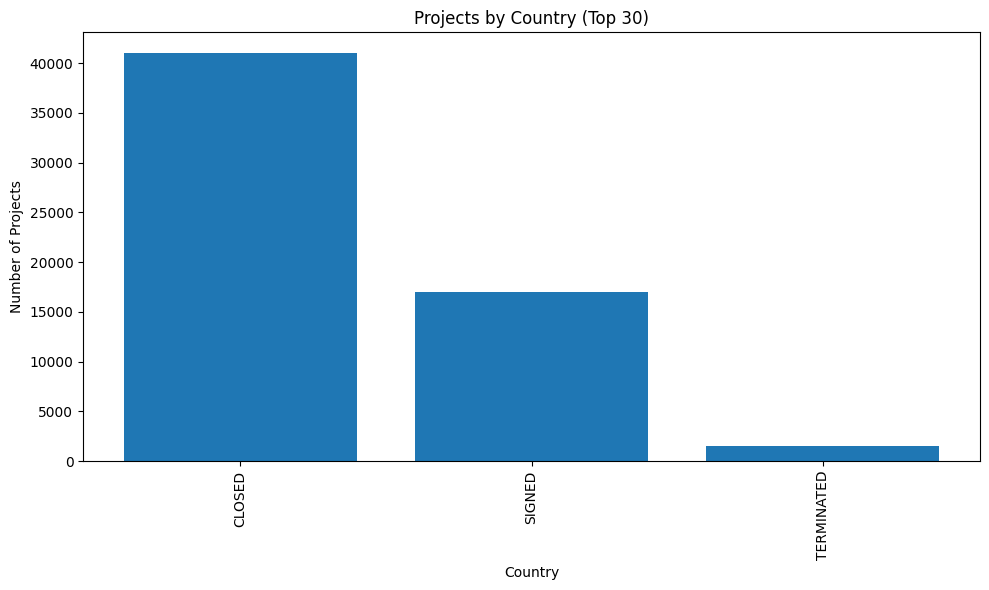

In [15]:
import matplotlib.pyplot as plt
countries = (
    consolidated
    .filter(pl.col("status").is_not_null())
    .group_by("status")
    .count()
    .rename({"count": "project_count"})
    .sort("project_count", descending=True)
)

country_names  = countries["status"].to_list()[:30]
project_counts = countries["project_count"].to_list()[:30]

plt.figure(figsize=(10, 6))
plt.bar(country_names, project_counts)
plt.title("Projects by Country (Top 30)")
plt.xlabel("Country")
plt.ylabel("Number of Projects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


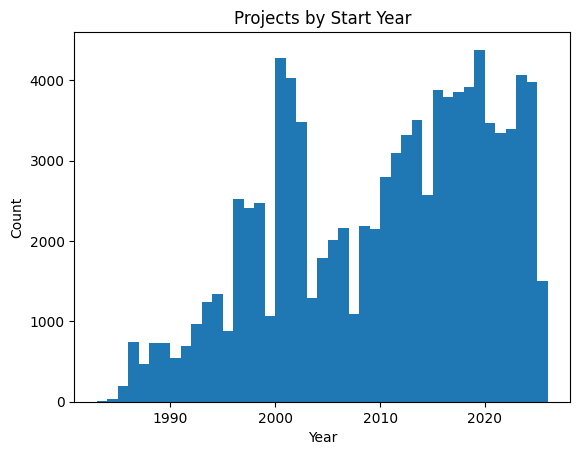

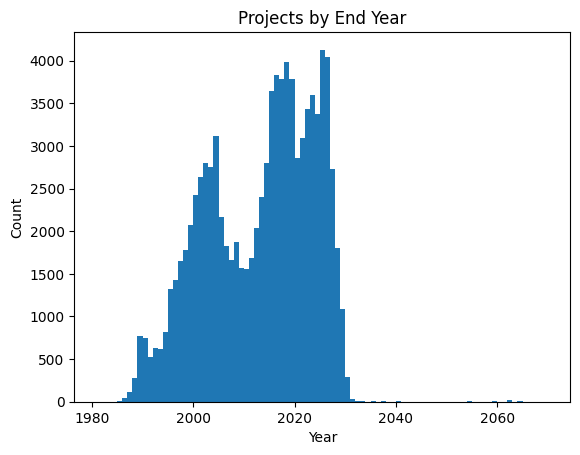

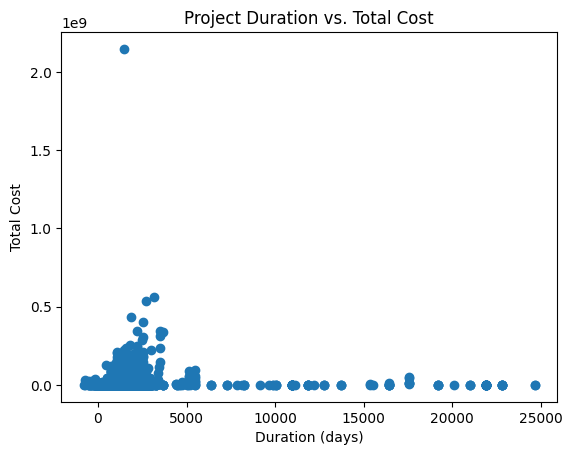

C:\Users\Romain\AppData\Local\Temp\ipykernel_2396\478720037.py:82: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


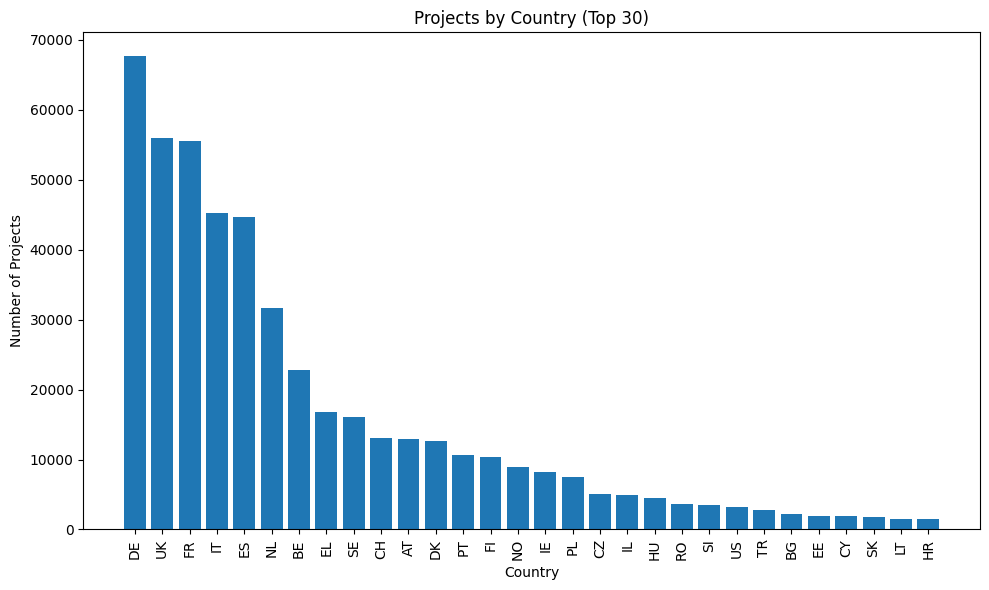

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import pathlib
from itertools import combinations
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import folium

# Paths
ROOT    = pathlib.Path(r"C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS")
OUTDIR  = ROOT / "combined"
PARQUET = OUTDIR / "consolidated.parquet"
PROJECT_PUB = OUTDIR / "projectPublications_all.parquet"

# Load consolidated dataset
df = pl.read_parquet(PARQUET)

for col in ["startDate", "endDate"]:
    if df[col].dtype == pl.Utf8:
        df = df.with_column(
            pl.col(col).str.strptime(pl.Date, "%Y-%m-%d").alias(col)
        )

df = df.with_columns(
    pl.col("list_netEcContribution").list.eval(pl.element().cast(pl.Float64),parallel=True)
    .list.sum().alias("netEcContribution")
)

df = df.with_columns(
    pl.col("totalCost").cast(pl.Float64),
    pl.col("netEcContribution").cast(pl.Float64)
)

df = df.with_columns([
    pl.col("startDate").dt.year().alias("startYear"),
    pl.col("endDate").  dt.year().alias("endYear"),
    (pl.col("endDate") - pl.col("startDate")).dt.total_days().alias("durationDays"),
    (pl.col("netEcContribution") / pl.col("totalCost")).alias("ecRatio"),
])

# 1. Histogram of project start years
years = [y for y in df["startYear"].to_list() if y is not None]
plt.figure()
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Projects by Start Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

# 2. Histogram of project end years
end_years = [y for y in df["endYear"].to_list() if y is not None]
plt.figure()
plt.hist(end_years, bins=range(min(end_years), max(end_years) + 1))
plt.title("Projects by End Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

# 3. Duration vs. Total Cost scatter plot
valid = df.filter(
    pl.col("durationDays").is_not_null() &
    pl.col("totalCost").   is_not_null()
)
durations = valid["durationDays"].to_list()
costs     = valid["totalCost"].    to_list()
plt.figure()
plt.scatter(durations, costs)
plt.title("Project Duration vs. Total Cost")
plt.xlabel("Duration (days)")
plt.ylabel("Total Cost")
plt.show()


# 4. Country breakdown (first country in list_country)
countries = (
    df
    .explode("list_country")
    .filter(pl.col("list_country").is_not_null())
    .group_by("list_country")
    .count()
    .rename({"count": "project_count"})
    .sort("project_count", descending=True)
)

country_names  = countries["list_country"].to_list()[:30]
project_counts = countries["project_count"].to_list()[:30]

plt.figure(figsize=(10, 6))
plt.bar(country_names, project_counts)
plt.title("Projects by Country (Top 30)")
plt.xlabel("Country")
plt.ylabel("Number of Projects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# 5. Geo scatter (parse "lat, lon" from list_geolocation)
locs = (
    df
    .explode("list_geolocation")
    .filter(pl.col("list_geolocation").is_not_null())
)

locs = locs.with_columns(
    pl.col("list_geolocation")
      .str.split(",")
      .alias("geo_split")
)

locs = locs.with_columns([
    pl.col("geo_split")
      .list.get(0)             
      .str.strip_chars().str.replace(r"[^\d\.\-]", "", literal=False)
      .cast(pl.Float64)       
      .alias("lat"),
    pl.col("geo_split")
      .list.get(1)
      .str.strip_chars().str.replace(r"[^\d\.\-]", "", literal=False)
      .cast(pl.Float64)
      .alias("lon"),
])

locs = locs.filter(pl.col("lat").is_not_null() & pl.col("lon").is_not_null())

lats = locs["lat"].to_list()
lons = locs["lon"].to_list()

center_lat = sum(lats) / len(lats)
center_lon = sum(lons) / len(lons)

m = folium.Map(location=[center_lat, center_lon], zoom_start=4, tiles="CartoDB positron")

for lat, lon in zip(lats, lons):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m

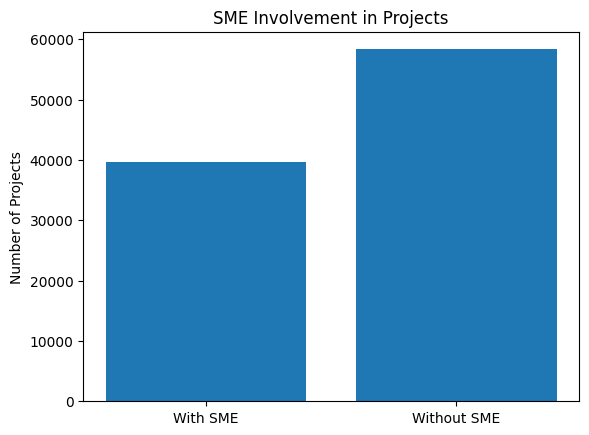

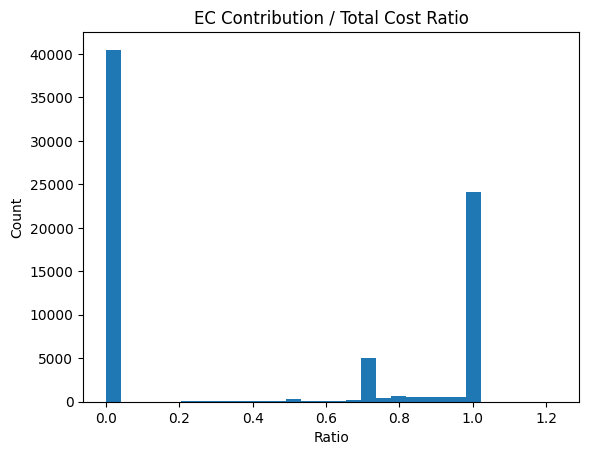

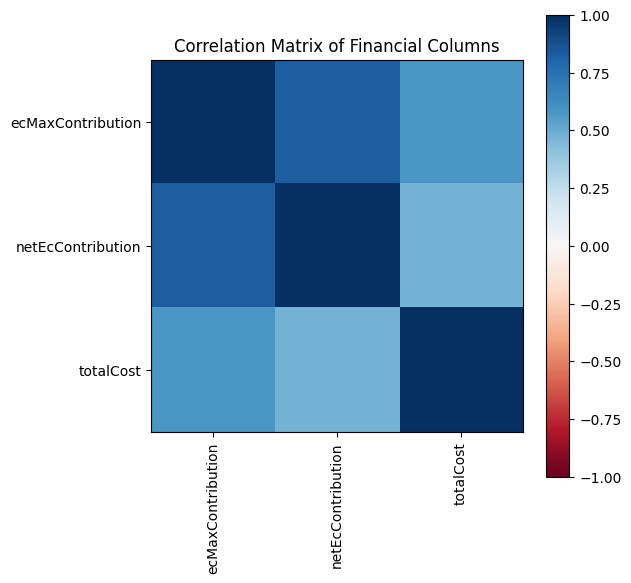

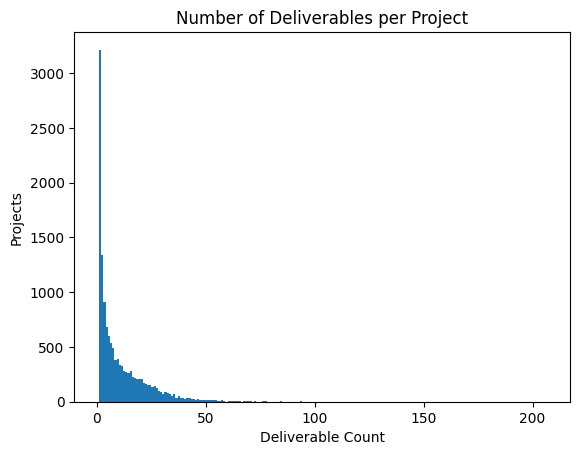

C:\Users\Romain\AppData\Local\Temp\ipykernel_14980\3443882100.py:59: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


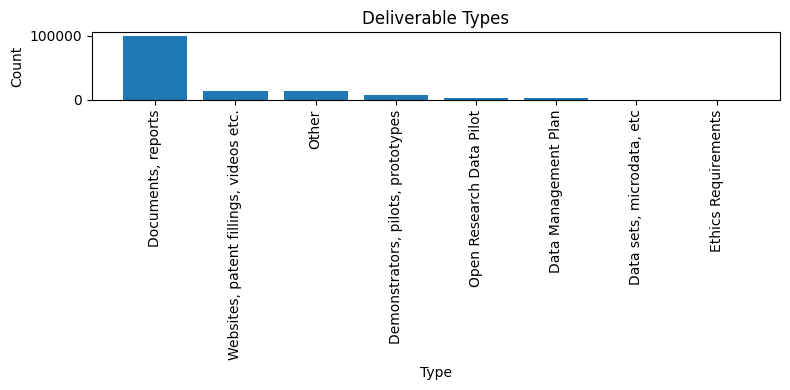

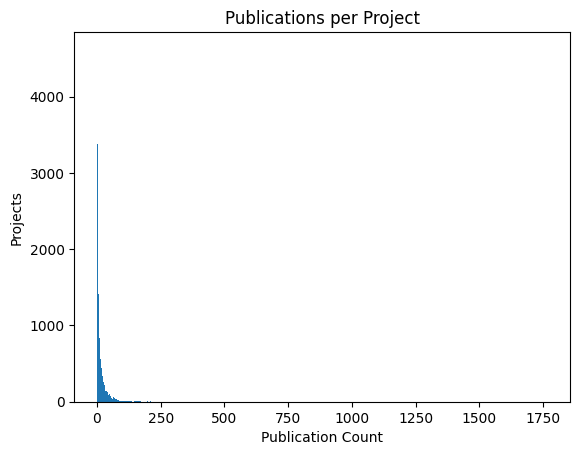

TypeError: can only concatenate str (not "int") to str

<Figure size 640x480 with 0 Axes>

In [ ]:
import math
# ── 6. SME involvement rate ────────────────────────────────────────────────
sme_lists = df["list_SME"].drop_nulls().to_list()
sme_flag  = [any(lst) for lst in sme_lists]
count_sme = sum(sme_flag)
count_non = len(sme_flag) - count_sme

plt.figure()
plt.bar(["With SME", "Without SME"], [count_sme, count_non])
plt.title("SME Involvement in Projects")
plt.ylabel("Number of Projects")
plt.show()


# ── 7. EC contribution ratio histogram ────────────────────────────────────
raw_ratios = df["ecRatio"].drop_nulls().to_list()
ec_ratios = [r for r in raw_ratios if math.isfinite(r)]

plt.figure()
plt.hist(ec_ratios, bins=30)
plt.title("EC Contribution / Total Cost Ratio")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.show()


# ── 8. Correlation matrix of financials ───────────────────────────────────
fin_df = (
    df
    .select(["ecMaxContribution", "netEcContribution", "totalCost"])
    .drop_nulls()
    .to_pandas()
)
corr = fin_df.corr()
plt.figure(figsize=(6,6))
plt.imshow(corr.values, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Financial Columns")
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.show()


# ── 9. Deliverables per project ────────────────────────────────────────────
deliv_counts = [len(lst) for lst in df["list_deliverableType"].drop_nulls().to_list()]
plt.figure()
plt.hist(deliv_counts, bins=range(max(deliv_counts)+2))
plt.title("Number of Deliverables per Project")
plt.xlabel("Deliverable Count")
plt.ylabel("Projects")
plt.show()


# ── 10. Deliverable types frequency ───────────────────────────────────────
types = (
    df.explode("list_deliverableType")
      .filter(pl.col("list_deliverableType").is_not_null())
      .group_by("list_deliverableType")
      .count()
      .sort("count", descending=True)
)
plt.figure(figsize=(8,4))
plt.bar(types["list_deliverableType"].to_list(),
        types["count"].to_list())
plt.title("Deliverable Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ── 11. Publications per project ──────────────────────────────────────────
pub_counts = [len(lst) for lst in df["list_doi"].drop_nulls().to_list()]
plt.figure()
plt.hist(pub_counts, bins=range(max(pub_counts)+2))
plt.title("Publications per Project")
plt.xlabel("Publication Count")
plt.ylabel("Projects")
plt.show()


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import pathlib
from itertools import combinations
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import folium

# Paths
ROOT    = pathlib.Path(r"C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 2\Semester 2\Modern Data Analytics\CORDIS")
OUTDIR  = ROOT / "combined"
PARQUET = OUTDIR / "consolidated.parquet"
PROJECT_PUB = OUTDIR / "projectPublications_all.parquet"

# Load consolidated dataset
df = pl.read_parquet(PARQUET)

for col in ["startDate", "endDate"]:
    if df[col].dtype == pl.Utf8:
        df = df.with_column(
            pl.col(col).str.strptime(pl.Date, "%Y-%m-%d").alias(col)
        )

df = df.with_columns(
    pl.col("list_netEcContribution").list.eval(pl.element().cast(pl.Float64),parallel=True)
    .list.sum().alias("netEcContribution")
)

df = df.with_columns(
    pl.col("totalCost").cast(pl.Float64),
    pl.col("netEcContribution").cast(pl.Float64)
)

df = df.with_columns([
    pl.col("startDate").dt.year().alias("startYear"),
    pl.col("endDate").  dt.year().alias("endYear"),
    (pl.col("endDate") - pl.col("startDate")).dt.total_days().alias("durationDays"),
    (pl.col("netEcContribution") / pl.col("totalCost")).alias("ecRatio"),
])

In [ ]:
# ── 12. Yearly publication trends ─────────────────────────────────────────
pubs = (
    df
    .explode("list_publishedYear")
    .filter(pl.col("list_publishedYear").is_not_null())
)

pubs_by_year = (
    pubs
    .with_columns(
        pl.col("list_publishedYear")
          .cast(pl.Int32, strict=False) 
          .alias("year_int")
    )
    .filter(pl.col("year_int").is_not_null())
    .group_by("year_int")
    .len()
    .sort("year_int")
)

# 3) Bar‑plot the small table
years  = pubs_by_year["year_int"].to_list()
counts = pubs_by_year["count"].to_list()

plt.figure(figsize=(8,4))
plt.bar(years, counts)
plt.title("Publications by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ── 13. Topic frequency ───────────────────────────────────────────────────
topics = (
    df.explode("list_topic")
      .filter(pl.col("list_topic").is_not_null())
      .group_by("list_topic")
      .count()
      .sort("count", descending=True)
      .head(20)
)
plt.figure(figsize=(8,4))
plt.bar(topics["list_topic"].to_list(), topics["count"].to_list())
plt.title("Top 20 Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ── 14. Legal basis distribution ──────────────────────────────────────────
legal = (
    df.explode("list_legalBasis")
      .filter(pl.col("list_legalBasis").is_not_null())
      .group_by("list_legalBasis")
      .count()
      .sort("count", descending=True)
)
plt.figure(figsize=(8,4))
plt.bar(legal["list_legalBasis"].to_list(), legal["count"].to_list())
plt.title("Legal Basis Distribution")
plt.xlabel("Legal Basis")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ── 15. Web link status (archived vs. active) ────────────────────────────
links = df.explode("list_archivedDate").drop_nulls(subset=["list_archivedDate"])
archived_flags = [bool(d) for d in links["list_archivedDate"].to_list()]
count_arch = sum(archived_flags)
count_act  = len(archived_flags) - count_arch
plt.figure()
plt.bar(["Archived", "Active"], [count_arch, count_act])
plt.title("Web Link Status")
plt.ylabel("Count")
plt.show()


# ── 16. Language coverage ─────────────────────────────────────────────────
langs = (
    df.explode("list_availableLanguages")
      .filter(pl.col("list_availableLanguages").is_not_null())
      .group_by("list_availableLanguages")
      .count()
      .sort("count", descending=True)
)
plt.figure(figsize=(8,4))
plt.bar(langs["list_availableLanguages"].to_list(),
        langs["count"].to_list())
plt.title("Web Link Language Coverage")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ── 17. Attachment types ──────────────────────────────────────────────────
attach = (
    df.explode("list_attachment")
      .filter(pl.col("list_attachment").is_not_null())
)
exts = [pathlib.Path(x).suffix.lower() for x in attach["list_attachment"].to_list()]
ext_counts = {e: exts.count(e) for e in set(exts)}
plt.figure()
plt.bar(list(ext_counts.keys()), list(ext_counts.values()))
plt.title("Attachment File Types")
plt.xlabel("Extension")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ── 18. Summary title lengths ─────────────────────────────────────────────
titles = (
    df.explode("list_title_report")
      .filter(pl.col("list_title_report").is_not_null())
)
title_lens = [len(t) for t in titles["list_title_report"].to_list()]
plt.figure()
plt.hist(title_lens, bins=30)
plt.title("Report Title Lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


# ── 19. Topic vs. Funding: average totalCost by topic ─────────────────────
avg_cost = (
    df.explode("list_topic")
      .filter(pl.col("list_topic").is_not_null() & pl.col("totalCost").is_not_null())
      .group_by("list_topic")
      .agg(pl.col("totalCost").mean().alias("avgCost"))
      .sort("avgCost", descending=True)
      .head(20)
)
plt.figure(figsize=(8,4))
plt.bar(avg_cost["list_topic"].to_list(), avg_cost["avgCost"].to_list())
plt.title("Average Project Cost by Topic")
plt.xlabel("Topic")
plt.ylabel("Average Cost")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ── 20. Time to first publication ─────────────────────────────────────────
pub_df = (
    pl.read_parquet(PROJECT_PUB)
      .with_columns(
         pl.col("contentUpdateDate")
           .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
           .dt.date()
           .alias("pubDate")
      )
      .drop_nulls(subset=["pubDate", "projectID"])
)
first_pub = pub_df.group_by("projectID").agg(pl.col("pubDate").min().alias("firstPub"))
merged    = df.join(first_pub, left_on="id", right_on="projectID", how="left")
lags      = (
    merged
    .filter(pl.col("firstPub").is_not_null() & pl.col("startDate").is_not_null())
    .with_column((pl.col("firstPub") - pl.col("startDate")).dt.days().alias("lagDays"))
    ["lagDays"]
    .to_list()
)
plt.figure()
plt.hist(lags, bins=30)
plt.title("Days from Start to First Publication")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()


# ── 21. Objective text clustering (TF-IDF + KMeans + t-SNE) ─────────────
objectives = [o for o in df["objective"].drop_nulls().to_list() if o.strip()]
vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
X = vectorizer.fit_transform(objectives)
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
# only embed the first 500 for speed
coords = TSNE(n_components=2, random_state=42).fit_transform(X[:500].toarray())

plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], s=10, alpha=0.6)
plt.title("Objective Clusters (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

In [ ]:
from ydata_profiling import ProfileReport
report = ProfileReport(
    consolidated.to_pandas(),
    title="Polars EDA Report",
    explorative=True
)
report.to_file("polars_report.html")

c:\Users\Romain\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Romain\AppData\Local\Temp\ipykernel_22464\834880225.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
c:\Users\Romain\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\profile_report.py:365: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(
Summarize dataset:   9%|▉         | 6/68 [00:04<00:34,  1.77it/s, Describe variable: list_deliverableType]

In [7]:
consolidated.head()

id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,list_deliverableType,list_url,list_contentUpdateDate,list_authors,list_title,list_doi,list_journalTitle,list_isPublishedAs,list_publishedYear,list_contentUpdateDate_publi,list_title_report,list_attachment,list_contentUpdateDate_report,list_organisationID,list_country,list_name,list_SME,list_city,list_geolocation,list_organizationURL,list_role,list_ecContribution,list_netEcContribution,list_totalCost,list_endOfParticipation,list_activityType,list_contentUpdateDate_org,list_physUrl,list_availableLanguages,list_status,list_archivedDate,list_type,list_source,list_represents,list_legalBasis,list_title_legal,list_uniqueProgrammePart,list_topic,list_title_topic,list_euroSciVocTitle,list_euroSciVocPath,list_description
i64,str,str,str,date,date,f64,f64,str,str,date,str,str,str,str,str,str,datetime[μs],i64,str,list[str],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[i64],list[datetime[μs]],list[str],list[str],list[datetime[μs]],list[i64],list[str],list[str],list[bool],list[str],list[str],list[str],list[str],list[f64],list[f64],list[f64],list[bool],list[str],list[datetime[μs]],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[bool],list[str],list[str],list[str],list[str],list[str]
101116741,"""DOE""","""SIGNED""","""Digitizing Other Economies: A …",2024-02-01,2029-01-31,1.499998e6,1.499998e6,"""HORIZON.1.1""","""ERC-2023-STG""",2023-12-15,"""HORIZON""","""ERC-2023-STG""","""ERC-2023-STG""","""HORIZON-ERC""",null,"""How do longstanding, primarily…",2023-12-26 14:40:12,259247,"""10.3030/101116741""",null,null,null,null,null,null,null,null,null,null,null,null,null,[999981634],"[""NL""]","[""WAGENINGEN UNIVERSITY""]",[false],"[""Wageningen""]","[""51.9863279,5.6679366""]","[""http://www.wageningenur.nl/nl.htm""]","[""coordinator""]",[1.499998e6],[1.499998e6],[1.499998e6],[false],"[""HES""]",[2023-12-26 14:40:12],null,null,null,null,null,null,null,"[""HORIZON.1.1""]","[""European Research Council (ERC)""]",[true],"[""ERC-2023-STG""]","[""ERC STARTING GRANTS""]","[""government systems""]","[""/social sciences/political sciences/government systems""]",[null]
101163161,"""IRASTRO""","""SIGNED""","""MOLECULAR QUANTUM DYNAMICS IN …",2025-08-01,2031-07-31,1.2085363e7,1.2085363e7,"""HORIZON.1.1""","""ERC-2024-SyG""",2025-02-20,"""HORIZON""","""ERC-2024-SyG""","""ERC-2024-SyG""","""HORIZON-ERC-SYG""",null,"""The James Webb Space Telescope…",2025-02-24 17:23:14,268970,"""10.3030/101163161""",null,null,null,null,null,null,null,null,null,null,null,null,null,"[999997736, 999854855, 999990267]","[""DK"", ""DE"", ""DE""]","[""AARHUS UNIVERSITET"", ""UNIVERSITAET POTSDAM"", ""MAX-PLANCK-GESELLSCHAFT ZUR FORDERUNG DER WISSENSCHAFTEN EV""]","[false, false, false]","[""Aarhus C"", ""Potsdam"", ""Munchen""]","[""56.171028,10.199381"", ""52.3979172,13.0146272"", ""48.1411687,11.5822929""]","[""http://www.au.dk"", ""http://www.uni-potsdam.de"", ""http://www.mpg.de""]","[""participant"", ""participant"", ""coordinator""]","[4.24624e6, 1.982813e6, 5.85631e6]","[4.24624e6, 1.982813e6, 5.85631e6]","[4.24624e6, 1.982813e6, 5.85631e6]","[false, false, false]","[""HES"", ""HES"", ""REC""]","[2025-02-24 17:23:14, 2025-02-24 17:23:14, 2025-02-24 17:23:14]",null,null,null,null,null,null,null,"[""HORIZON.1.1""]","[""European Research Council (ERC)""]",[true],"[""ERC-2024-SyG""]","[""ERC SYNERGY GRANTS""]","[""grains and oilseeds"", ""microscopy"", … ""spectroscopy""]","[""/agricultural sciences/agriculture, forestry, and fisheries/agriculture/grains and oilseeds"", ""/natural sciences/physical sciences/optics/microscopy"", … ""/natural sciences/physical sciences/optics/spectroscopy""]","[null, null, … null]"
101160499,"""In-phase""","""SIGNED""","""Multiscale modelling of aberra…",2025-06-01,

In [5]:
%pip install SPARQLWrapper

   ---------------------------------------- 0.0/565.1 kB ? eta -:--:--
   ---------------------------------------- 565.1/565.1 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\romain\appdata\local\programs\python\python311\lib\site-packages\holehe-1.61-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import os
import json
import argparse
from datetime import datetime
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Optional, Literal

import polars as pl  # pip install polars
from SPARQLWrapper import SPARQLWrapper, JSON  # pip install SPARQLWrapper
#from langchain.docstore.document import Document  # pip install langchain
#from langchain.embeddings import OpenAIEmbeddings  # pip install langchain openai
#from langchain.vectorstores import FAISS  # pip install faiss-cpu
#from langchain.llms import OpenAI  # pip install openai
#from langchain.chains import RetrievalQA

###############################################################################
# Configuration                                                               #
###############################################################################

SPARQL_ENDPOINT = "https://cordis.europa.eu/datalab/sparql"
CACHE_PATH      = "cache.json"              # master cache for projects core
INDEX_DIR       = "faiss_horizon"          # FAISS persistence dir
MAX_ROWS        = 25_000                    # protective cap per query

PREFIXES = """
PREFIX eurio: <http://data.europa.eu/s66#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX foaf:   <http://xmlns.com/foaf/0.1/>
PREFIX schema: <http://schema.org/>
PREFIX skos:   <http://www.w3.org/2004/02/skos/core#>
"""

QUERIES: Dict[str, str] = {
    # ────────────────────────────────────────────────────────── core project
    "projects": f"""{PREFIXES}
    SELECT ?projectID ?title ?abstract ?start ?end ?status
    WHERE {{
      ?p a eurio:Project ;
         dct:title ?title ;
         dct:abstract ?abstract ;
         eurio:projectID ?projectID .
      OPTIONAL {{ ?p eurio:startDate ?start. }}
      OPTIONAL {{ ?p eurio:endDate ?end. }}
      OPTIONAL {{ ?p eurio:projectStatus ?status. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── deliverables
    "deliverable": f"""{PREFIXES}
    SELECT ?projectID ?deliverableType ?url ?contentUpdateDate
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:hasDeliverable ?d .
      OPTIONAL {{ ?d eurio:deliverableType ?deliverableType. }}
      OPTIONAL {{ ?d eurio:url ?url. }}
      OPTIONAL {{ ?d eurio:contentUpdateDate ?contentUpdateDate. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── publications
    "publication": f"""{PREFIXES}
    SELECT ?projectID ?authors ?title ?doi ?journalTitle ?isPublishedAs ?publishedYear ?contentUpdateDate
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:producedPublication ?pub .
      OPTIONAL {{ ?pub dct:title ?title. }}
      OPTIONAL {{ ?pub eurio:authors ?authors. }}
      OPTIONAL {{ ?pub eurio:doi ?doi. }}
      OPTIONAL {{ ?pub eurio:journalTitle ?journalTitle. }}
      OPTIONAL {{ ?pub eurio:isPublishedAs ?isPublishedAs. }}
      OPTIONAL {{ ?pub eurio:publishedYear ?publishedYear. }}
      OPTIONAL {{ ?pub eurio:contentUpdateDate ?contentUpdateDate. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── organisation
    "organisation": f"""{PREFIXES}
    SELECT ?projectID ?organisationID ?country ?name ?SME ?city ?geolocation ?organizationURL ?role ?ecContribution ?netEcContribution ?totalCost ?endOfParticipation ?activityType ?contentUpdateDate
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:hasParticipant ?org .
      OPTIONAL {{ ?org eurio:organisationID ?organisationID. }}
      OPTIONAL {{ ?org schema:addressCountry ?country. }}
      OPTIONAL {{ ?org foaf:name|schema:name ?name. }}
      OPTIONAL {{ ?org eurio:SME ?SME. }}
      OPTIONAL {{ ?org schema:addressLocality ?city. }}
      OPTIONAL {{ ?org eurio:hasCoordinates ?geolocation. }}
      OPTIONAL {{ ?org schema:url ?organizationURL. }}
      OPTIONAL {{ ?org eurio:role ?role. }}
      OPTIONAL {{ ?org eurio:ecContribution ?ecContribution. }}
      OPTIONAL {{ ?org eurio:netEcContribution ?netEcContribution. }}
      OPTIONAL {{ ?org eurio:totalCost ?totalCost. }}
      OPTIONAL {{ ?org eurio:endOfParticipation ?endOfParticipation. }}
      OPTIONAL {{ ?org eurio:activityType ?activityType. }}
      OPTIONAL {{ ?org eurio:contentUpdateDate ?contentUpdateDate. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── EuroSciVoc
    "voc": f"""{PREFIXES}
    SELECT ?projectID ?euroSciVocTitle ?euroSciVocPath ?euroSciVocDescription
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:mainSubject ?v .
      OPTIONAL {{ ?v skos:prefLabel ?euroSciVocTitle. }}
      OPTIONAL {{ ?v skos:broader* ?path . ?path skos:prefLabel ?euroSciVocPath. }}
      OPTIONAL {{ ?v skos:definition ?euroSciVocDescription. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── topic call
    "topic": f"""{PREFIXES}
    SELECT ?projectID ?topic ?title
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:relatedTopic ?t .
      OPTIONAL {{ ?t skos:notation ?topic. }}
      OPTIONAL {{ ?t skos:prefLabel ?title. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── web link
    "weblink": f"""{PREFIXES}
    SELECT ?projectID ?physUrl ?availableLanguages ?status ?archivedDate ?type ?source ?represents
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:hasWebSite ?w .
      OPTIONAL {{ ?w eurio:physUrl ?physUrl. }}
      OPTIONAL {{ ?w eurio:availableLanguages ?availableLanguages. }}
      OPTIONAL {{ ?w eurio:status ?status. }}
      OPTIONAL {{ ?w eurio:archivedDate ?archivedDate. }}
      OPTIONAL {{ ?w eurio:type ?type. }}
      OPTIONAL {{ ?w eurio:source ?source. }}
      OPTIONAL {{ ?w eurio:represents ?represents. }}
    }}
    LIMIT {MAX_ROWS}
    """,

    # ────────────────────────────────────────────────────────── legal basis
    "legal": f"""{PREFIXES}
    SELECT ?projectID ?legalBasis ?title ?uniqueProgrammePart
    WHERE {{
      ?p a eurio:Project ; eurio:projectID ?projectID ; eurio:legalBasis ?l .
      OPTIONAL {{ ?l dct:title ?title. }}
      OPTIONAL {{ ?l eurio:legalBasis ?legalBasis. }}
      OPTIONAL {{ ?l eurio:uniqueProgrammePart ?uniqueProgrammePart. }}
    }}
    LIMIT {MAX_ROWS}
    """,
}

###############################################################################
# Generic SPARQL runner                                                       #
###############################################################################

def _run(query: str) -> List[Dict[str, str]]:
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    print(sparql.query().convert()["results"])
    bindings = sparql.query().convert()["results"]["bindings"]
    rows: List[Dict[str, str]] = []
    for b in bindings:
        rows.append({k: v["value"] for k, v in b.items()})
    return rows

###############################################################################
# Hydration (replicating your Polars parquet workflow)                        #
###############################################################################

def hydrate_entities(out_dir: Optional[str] = None, force: bool = False) -> Dict[str, pl.DataFrame]:
    """Download every QUERY in QUERIES and return {name: Polars DF}. Optionally
    save each to `<out_dir>/<name>.parquet`."""
    out: Dict[str, pl.DataFrame] = {}
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    for name, query in QUERIES.items():
        path = None if not out_dir else os.path.join(out_dir, f"{name}.parquet")
        if path and os.path.exists(path) and not force:
            print(f"[cache] {name} – reading cached parquet")
            df = pl.read_parquet(path)
            #print(df)
        else:
            print(f"[SPARQL] Fetching {name} …")
            rows = _run(query)
            print(rows)
            df = pl.from_dicts(rows)
            if path:
                df.write_parquet(path)
                print(f"[save] {name} → {path}  (rows={df.shape[0]})")
        out[name] = df
    return out


In [30]:
hydrate_entities(r"C:\Users\Romain\OneDrive - KU Leuven\MDA")

[cache] projects – reading cached parquet
[SPARQL] Fetching deliverable …
{'distinct': False, 'ordered': True, 'bindings': []}
[]


NoDataError: no data, cannot infer schema

In [37]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint = "https://cordis.europa.eu/datalab/sparql"
query = """
PREFIX eurio: <http://data.europa.eu/s66#>
SELECT ?project_title ?projectID
WHERE {
  ?project a eurio:Result .
  ?project eurio:title ?project_title .
  ?project eurio:projectID ?projectID .
}
ORDER BY ?project_title
LIMIT 100
OFFSET 1000
"""

sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results = sparql.query().convert()
print(results)
for row in results["results"]["bindings"]:
    print(row["projectID"]["value"], "→", row["title"]["value"])

{'head': {'link': [], 'vars': ['project_title', 'projectID']}, 'results': {'distinct': False, 'ordered': True, 'bindings': []}}
